# 北尾早霧・砂川武貴・山田知明『定量的マクロ経済学と数値計算』日本評論社
## 第2章：2期間モデル・3期間モデルと数値計算の概観

## 2.7 内生的格子法（Endogenous Gridpoint Method）

### パラメータの設定はこれまでと同じ
* ただし、EGMではwではなくaについてグリッドポイントを取るので、wをaに適宜変更

In [1]:
struct Models
    # パラメータ
    β::Float64 #割引因子
    γ::Float64 #相対的危険回避度
    
    # 要素価格
    rent::Float64 #純利子率
    
    # グリッド
    na::Int64 #貯蓄グリッドの数
    a_max::Float64 #貯蓄グリッドの最大値
    a_min::Float64 #貯蓄グリッドの最小値
    grid_a::Vector{Float64} #貯蓄グリッド
end

In [2]:
function Calibration()
    # パラメータはここで設定をする
    β = 0.985^30
    γ = 2.0
    rent = 1.025^30 - 1.0
    na = 11
    a_max = 0.4
    a_min = 0.0

    grid_a = collect(LinRange(a_min, a_max, na))

    return Models(β, γ, rent, na, a_max, a_min, grid_a)
end

Calibration (generic function with 1 method)

In [3]:
params = Calibration();

---

## 経済学でよく使う関数を設定しておく
* 限界効用
$$
    u'(c) = c^{-\gamma}
$$

In [4]:
function mu_CRRA(cons, γ)
    return cons^(-γ)
end

mu_CRRA (generic function with 1 method)

---

### オイラー方程式の右辺を関数化

In [5]:
function rhs_euler(a::Float64, params::Models)

    # 老年期の限界効用
    mu = mu_CRRA((1.0 + params.rent)*a, params.γ)

    # オイラー方程式の右辺
    return params.β*(1.0 + params.rent)*mu

end

rhs_euler (generic function with 1 method)

### CRRA型効用関数の逆関数

In [6]:
function inv_mu_CRRA(mu, γ)
    return mu^(-1/γ)
end

inv_mu_CRRA (generic function with 1 method)

---

## 計算アルゴリズムのメインパート
* OptimizationやRootを探すといった事を一切していない！

In [7]:
# 空の変数を用意
rhs = zeros(params.na)
cons = zeros(params.na)

for j = 1:params.na
    # オイラー方程式の右辺を計算
    rhs[j] = rhs_euler(params.grid_a[j], params)
    # 逆関数から若年期の消費を計算
    cons[j] = inv_mu_CRRA(rhs[j], params.γ)
end

## 予算制約からwを逆算する
* ⬆で計算した$c_{j}$に対応する$w_{j}$を予算制約から計算

In [8]:
w = zeros(params.na)
for j = 1:params.na
    w[j] = cons[j] + params.grid_a[j]
end
print(w)

[0.0, 0.11267323864644622, 0.22534647729289245, 0.3380197159393386, 0.4506929545857849, 0.5633661932322311, 0.6760394318786772, 0.7887126705251233, 0.9013859091715698, 1.0140591478180159, 1.1267323864644623]

In [9]:
# ⬆の書き方はグリッド毎に計算している点をあえて明示的に書いているが、⬇の書き方でOK
w = cons + params.grid_a

11-element Vector{Float64}:
 0.0
 0.11267323864644622
 0.22534647729289245
 0.3380197159393386
 0.4506929545857849
 0.5633661932322311
 0.6760394318786772
 0.7887126705251233
 0.9013859091715698
 1.0140591478180159
 1.1267323864644623

---

## 計算結果を出力

In [10]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [11]:
# 解析解
# テキストの(2.4)式
coef1 = (params.β*(1.0+params.rent))^(-1.0/params.γ)
coef2 = 1.0/(1.0+coef1*(1.0+params.rent))
a_cfs = coef2*w;

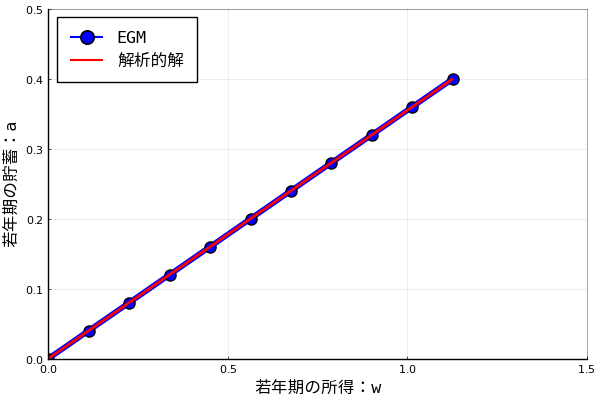

In [12]:
plt = plot(w, params.grid_a,
    color = :blue,
    marker = :circle,
    legend = :topleft,
    xlims = (0, 1.5),
    ylims = (0, 0.5),
    label = ("EGM"),
    xlabel = ("若年期の所得：w"),
    ylabel = ("若年期の貯蓄：a"),
    linewidth = 4,
    markersize = 8,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
plot!(w, a_cfs, linewidth = 2, color = :red, label="解析的解")
#savefig("../figure/Fig2_pol_egm.pdf")

---

## エクササイズ
* 内挿法(Interpolation)を学習後：$w$のグリッドがこれまで通り[0.1,1.0]上に10個で考えたい場合、どうすればよいだろうか。